<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW8/Get_all_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is copied from Miguel's notebook. My own notebook (HW8) used a much more complicated approach, which took too long to run for all objects. I used this notebook to generate the data for the next step (HW9)





In [39]:
import pandas as pd
import george
from george import kernels
from scipy import stats 
from scipy.optimize import minimize

In [5]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/MyDrive/ColabNotebooks/

/content/gdrive/MyDrive/ColabNotebooks


In [9]:
df = pd.read_csv('plasticc_train_lightcurves.csv.gz')

In [10]:
df.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


Shift time axis

In [11]:
mins = df.groupby(['object_id','passband'])['mjd'].min()
means = df.groupby(["object_id", "passband"])[["flux"]].mean()
stds = df.groupby(["object_id", "passband"])[["flux"]].std()
means_err = df.groupby(["object_id", "passband"])[["flux_err"]].mean()
stds_err = df.groupby(["object_id", "passband"])[["flux_err"]].std()

In [12]:
df['s_mjd'] = 0

In [13]:
df["fluxnormed"] = 0.
df["fluxnormed_err"] = 0.

In [31]:
def momentos(x, m):
  '''
  Returns the m-th moment of the data
  Receives an array and the moment desired as arguments
  '''
  return stats.moment(x, moment = m)

In [15]:
def shift_org(df):
  obj, band = df.object_id.values[0], df.passband.values[0]
  df["s_mjd"] = (df["mjd"] - mins.loc[obj, band])
  return df

In [18]:
def normed(df):
  obj, band = df.object_id.values[0], df.passband.values[0]
  df["fluxnormed"] = (df["flux"] - means.loc[obj, band].values[0]) / stds.loc[obj, band].values[0]
  df["fluxnormed_err"] = (df["flux_err"] - means_err.loc[obj, band].values[0]) / stds_err.loc[obj, band].values[0]
  return df

In [19]:
df = df.groupby(["object_id", "passband"]).apply(shift_org)

In [20]:
df = df.groupby(["object_id", "passband"]).apply(normed)

In [21]:
max_timeseries = df.groupby(['object_id','passband'])[['s_mjd']].max().reset_index()
max_timeseries.rename(columns = {'s_mjd' : 'max_time'}, inplace = True)

In [34]:
bandas = np.sort(df.passband.unique())

Interpolation

In [23]:
import numpy as np

In [22]:
N_samples = 100
upper_limit = 900

In [27]:
!pip install george

     |████████████████████████████████| 407 kB 9.8 MB/s 


In [28]:
import george
from george import kernels
from scipy import stats

In [24]:
t = np.linspace(0, 900, N_samples)

In [32]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet = True)

    # We took this line of code from the documentation to deal with the error
    # of a matrix non positive definite, that arises for some timeseries
    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet = True)

In [35]:
temp = df[(df.object_id==615) & (df.passband == bandas[0])]

In [36]:
y = temp.fluxnormed.values

In [40]:
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(1.4), kernels.CosineKernel(2))
gp = george.GP(kernel)
gp.compute(temp.s_mjd.values, temp.fluxnormed_err.values)

#Optimize the parameters
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)


In [41]:
pred, pred_var = gp.predict(temp.fluxnormed.values, temp.s_mjd.values, return_var=True)

In [42]:
pred1, pred_var1 = gp.predict(temp.fluxnormed.values, t, return_var=True)

In [51]:
import pylab as pl

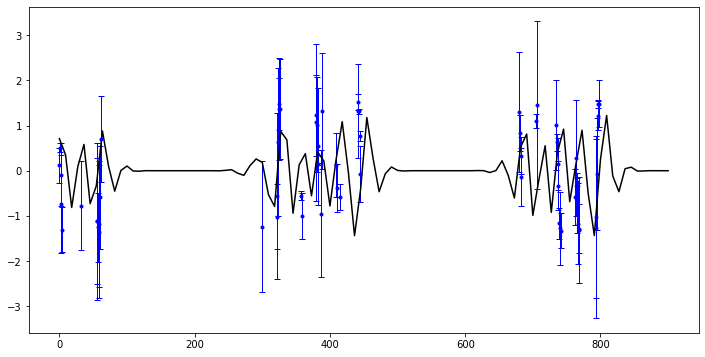

In [53]:
fig3 = pl.figure(figsize = (12,6))
#pl.plot(temp.s_mjd.values, pred, "k", lw=1.5, alpha=1)
pl.errorbar(temp.s_mjd.values , temp.fluxnormed.values, temp.fluxnormed_err.values, fmt='.', color='b', elinewidth=1, capsize=3)
pl.plot(t, pred1, 'k')

Store in (6 x M) x N dataframe

In [55]:
shape = df.object_id.unique().shape[0] * df.passband.unique().shape[0]

In [56]:
data = np.zeros((shape,N_samples))

In [59]:
objects = df["object_id"].unique()

In [60]:
for i, j in enumerate(objects):
  print(i)
  for k in range(6):
    temp = df[(df.object_id == j) & (df.passband == k)]
    y = temp.fluxnormed.values

    kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(3), kernels.CosineKernel(1.6))
    gp = george.GP(kernel)
    gp.compute(temp.s_mjd.values, temp.fluxnormed_err.values)

    #Optimize the parameters

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    gp.set_parameter_vector(result.x)

    pred, pred_var = gp.predict(temp.fluxnormed.values, t, return_var=True)

    data[6*i+k] = pred
    print(6*i+k)

Streaming output truncated to the last 5000 lines.
42802
42803
7134
42804
42805
42806
42807
42808
42809
7135
42810
42811
42812
42813
42814
42815
7136
42816
42817
42818
42819
42820
42821
7137
42822
42823
42824
42825
42826
42827
7138
42828
42829
42830
42831
42832
42833
7139
42834
42835
42836
42837
42838
42839
7140
42840
42841
42842
42843
42844
42845
7141
42846
42847
42848
42849
42850
42851
7142
42852
42853
42854
42855
42856
42857
7143
42858
42859
42860
42861
42862
42863
7144
42864
42865
42866
42867
42868
42869
7145
42870
42871
42872
42873
42874
42875
7146
42876
42877
42878
42879
42880
42881
7147
42882
42883
42884
42885
42886
42887
7148
42888
42889
42890
42891
42892
42893
7149
42894
42895
42896
42897
42898
42899
7150
42900
42901
42902
42903
42904
42905
7151
42906
42907
42908
42909
42910
42911
7152
42912
42913
42914
42915
42916
42917
7153
42918
42919
42920
42921
42922
42923
7154
42924
42925
42926
42927
42928
42929
7155
42930
42931
42932
42933
42934
42935
7156
42936
42937
42938
42939
42940


In [61]:
np.savetxt('data_all.csv', data, delimiter=',')